## 1. Collect Basic Data

### Retrieve CryptoCurrency Market Data ###

In [1]:
import pandas as pd
import yfinance as yf
from functools import reduce
import requests
import time
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


CRYPTO = False

# Crypto Details
cryptoProducts = ["ETH-USD", "USDT-USD", "BTC-USD"]
availableGranularities = dict(zip(["1M", "5M", "15M", "1H", "6H", "1D"], [60, 300, 900, 3600, 21600, 86400]))

# Stock Details
dowTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "ULVR.L"]  
period = "1D"
indexProducts = dowTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

if CRYPTO:
    productIds = cryptoProducts
    period = "1H"
    granularity = availableGranularities[period]
    API_THRESHOLD = 300 #Can only get 300 periods at a time from API
    PERIODS_WANTED = 10000

# not a chance
def retrieveCryptoData(productID, granularity, daysBack, endTime):
    API_URL = f"https://api.exchange.coinbase.com/products/{productID}/candles"
    daysBackDaysAgo = timedelta(days=daysBack)
    startTime = datetime.fromisoformat(endTime) - (granularity/86400) * daysBackDaysAgo

    # Convert to isoformat
    startTime = startTime.isoformat()

    # Set Request Parameters
    parameters = {
        "start" : startTime,
        "end" : endTime,
        "granularity" : str(granularity)
    }

    # Actually get data
    data = requests.get(API_URL, params = parameters, headers = {"content-type":"application/json"})
    df = pd.DataFrame(data.json(), columns=["time", "low", "high", "open", "close", "volume"])
    return df


def retrieveIndexData(ticker):
    # Define date range
    startDate = "2009-01-01"
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc


dataframes = dict()
RETRIEVE_DATA = False

if RETRIEVE_DATA:
    for productId in productIds:
        if CRYPTO:
            # Fetch PERIODS_WANTED periods of data
            end = (datetime.now()).isoformat()
            for batch in range(PERIODS_WANTED // API_THRESHOLD  + 1):
                amountToFetch = PERIODS_WANTED % API_THRESHOLD if batch == PERIODS_WANTED // API_THRESHOLD else API_THRESHOLD
                tempDF = retrieveCryptoData(productId, granularity, amountToFetch, end)
                timeInSeconds = (tempDF['time'].values)[-1]
                dt = datetime.fromtimestamp(timeInSeconds - granularity)
                end = dt.isoformat() + 'Z'
                value = dataframes.get(productId)
                if productId not in dataframes:
                    dataframes[productId] = tempDF[::-1]
                else:
                    dataframes[productId] = pd.concat([tempDF[::-1], dataframes[productId]])
        else:
            dataframe = retrieveIndexData(ticker=productId)
            columnNames = [value[1].lower() for value in list(dataframe.columns.values)]
            dataframe.columns = columnNames
            dataframes[productId] = dataframe
   
# Required for index data that pull stock data from different exchanges
def commonaliseData(data):
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    data = {ticker: df.dropna() for ticker, df in data.items()}
    PERIODS_WANTED = data.get(indexProducts[0]).shape[0]
    return data

if not CRYPTO and RETRIEVE_DATA:
    dataframes = commonaliseData(dataframes)

In [2]:
TEST_CORRECT_ORDER = False

if TEST_CORRECT_ORDER:
    testTime = dataframes[productIds[0]]['time'].values
    testTime -= testTime[0]
    plt.figure(figsize=(10, 6))
    plt.plot(testTime, color="blue")
    plt.title(f"Test Correct Order")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

## 2. Augment State Space (add indicators)

### Indicator 1: Exponential Moving Average ###

In [3]:
import matplotlib.pyplot as plt

def EMA(array, N):
    """
    EMA_t = (Price_t * α) + (EMA_(t-1) * (1 - α))
    where:
    EMA_t = Exponential Moving Average at time t
    Price_t = Price at time t
    α (alpha) = Smoothing factor, calculated as 2 / (N + 1)
    N = Number of periods
    """
    smoothingParameter = 2/(N + 1)
    finalArray = [array[0]]
    for i in range(1, len(array)):
        finalArray.append(array[i] * smoothingParameter + finalArray[i-1] * (1 - smoothingParameter))
    return np.array(finalArray)

# expMA = EMA(closingPrices, t)
# plt.figure(figsize=(10, 6))
# plt.plot(expMA, label=f"Exponential Moving Average: T={t}", color="red")
# plt.plot(closingPrices, label="Actual Closing Prices", color="blue")
# plt.title(f"Price Data")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

### Indicator 2: Momemtum

In [4]:
def Momentum(array):
    # Percentage Change in Price/Time
    momentumArray = [(array[i] - array[i-1]) /array[i-1] for i in range(1, len(array))]
    momentumArray.insert(0, np.nan)
    return np.array(momentumArray)

# momentum = Momentum(closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(momentum*100, color="green")
# plt.title(f"Momentum Data (as %)")
# plt.xlabel("Time")
# plt.ylabel("Momentum")
# plt.legend()
# plt.show()

### Indicator 3: Average True Range

In [5]:

def trueRange(high, low, close):
    # TR = Max[(H - L), |H - C|, |L - C|
    closing = np.insert(close, 0, np.nan, axis=0)[:len(close)]
    return np.maximum(high - low, np.abs(high - closing), np.abs(low - closing))

def averageTrueRange(high, low, close, n=14):
    trueRanges = trueRange(high, low, close)
    atr = np.empty_like(trueRanges)
    atr[:n] = np.nan  # First n values are NaN
    atr[n-1] = np.mean(trueRanges[:n])  # Initial ATR value (simple average of the first n TRs)
    for i in range(n+1, len(trueRanges)):
        atr[i] = (atr[i-1] * (n - 1) + trueRanges[i]) / n
    return atr

# aTRIndicator = averageTrueRange(highs, lows, closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(aTRIndicator, color="Brown")
# plt.title(f"Average True Range over Time")
# plt.xlabel("Time")
# plt.ylabel("Average True Range")
# plt.legend()
# plt.show()

### Indicator 4: Commodity Channel Index

In [6]:
def commodityChannelIndex(high, low, close, n=20):
    # (Typical Price - 20_Day Moving Average) / .015 x Mean Deviation
    typicalPrices = (high + low + close) / 3
    
    movingAverage = np.full_like(high, np.nan)
    meanDeviation = np.full_like(high, np.nan)
    
    for i in range(n, len(typicalPrices)):
        movingAverage[i] = np.mean(typicalPrices[i-n:i])
        meanDeviation[i] = np.mean(np.abs(typicalPrices[i-n:i] - movingAverage[i]))
    
    cci = np.full_like(high, np.nan, dtype=np.float64)

    numerator = typicalPrices[n:] - movingAverage[n:]
    denominator = 0.015 * meanDeviation[n:]
    result = np.empty_like(numerator)

    np.divide(numerator, denominator, out=result, where=(denominator != 0))
    # a little hacky...
    result[denominator == 0] = 0

    cci[n:] = result
    return cci

# # CCI = commodityChannelIndex(highs, lows, closingPrices)
# # plt.figure(figsize=(10, 6))
# # plt.plot(CCI, color="black")
# # plt.title(f"Commodity Channel Index over Time")
# # plt.xlabel("Time")
# # plt.ylabel("Commodity Channel Index")
# # plt.legend()
# # plt.show()

### Indicator 5: MACD

In [7]:
"""
MACD = 12-day EMA - 26-day EMA
Signal Line = 9-day EMA of MACD
MACD Histogram = MACD - Signal Line
where EMA stands for Exponential Moving Average
"""

def MACD(array):
    return EMA(array, 12) - EMA(array, 26)

def MACDSignal(array):
    return EMA(MACD(array), 9)

MACDHistogram = lambda x : MACD(x) - MACDSignal(x)

# mACD = MACD(closingPrices)
# signalLine = MACDSignal(closingPrices)
# macdHistogram = MACDHistogram(mACD, signalLine)

# plt.figure(figsize=(10, 6))
# plt.plot(mACD, color="blue", label = "MACD Line")
# plt.plot(signalLine, color = "red", label = "Signal Line")
# plt.plot(macdHistogram, color = "black", label = "Histogram")
# plt.title(f"Moving Average Convergence-Divergence")
# plt.xlabel("Time")
# plt.ylabel("MACD")
# plt.legend()
# plt.show()

## 3. Collate All Features Into DataFrame

In [8]:
import os

CCI_T, ATR_T = 20, 14
if RETRIEVE_DATA:
    for product in productIds:
        df = dataframes[product]
        close = df["close"].values
        volume = df["volume"].values
        highs = df["high"].values
        lows = df["low"].values
        df['E_M_A'] = EMA(close, N=30)
        df['Momentum'] = Momentum(close)
        df['Av_True_Range'] = averageTrueRange(highs, lows, close, 14)
        df['CCI'] = commodityChannelIndex(highs, lows, close, 20)
        df['MACDHist'] = MACDHistogram(close)
        df["Return"] = df["close"].pct_change().fillna(0)
        # Reset Indexes
        df = df.drop(columns=['open', 'high', 'volume', 'low'])
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first column

times = None
for product in productIds:
    df = dataframes[product]
    df = df.iloc[max(ATR_T, CCI_T):]
    times = df['Times']
    dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### Comparison Strategies

In [9]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
dowBuyAndHold = np.array([0] + [1/len(dowTickers) if i in dowTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

#Non
NON_RL_COMPARISON_STRATEGIES = {
    "SSEBuyAndHold" : sse50BuyAndHold,
    "SENSEXBuyAndHold" : sensexBuyAndHold,
    "FTSEBuyAndHold" : ftse100BuyAndHold,
    "DOWBuyAndHold" : dowBuyAndHold,
    "BuyAndHoldAll" : buyAndHoldAll
}

### Hyperparameters (most of them)

In [10]:
from collections import defaultdict


NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = 1 + (len((list(dataframes.values())[0]).columns)) * len(productIds)
if not CRYPTO:
    PERIODS_WANTED = list(dataframes.values())[0].shape[0]
EXPERIMENTS = 2
TRAINING_PERIODS = int(PERIODS_WANTED / EXPERIMENTS) # will probably have to change this to times
TIME_WINDOW = 30
LEARNING_FREQUENCIES = (TRAINING_PERIODS / np.array([10, 20, 30, 40, 50])).astype(int)
START_CASH = 1000000
LSTMHIDDENSIZE = 128
AGENT_RISK_AVERSIONS = np.array([1, 2, 3, 4, 5]) / 2 #i know, this probably shouldn't go here
STRATEGIES = ["PPOLSTM", "RANDOM"]
FINAL_STRATEGIES = STRATEGIES + ["SSEBuyAndHold", "SENSEXBuyAndHold", "FTSEBuyAndHold", "DOWBuyAndHold", "BuyAndHoldAll"]
REPEATS = 10
LSTMOUTPUTSIZES = [64, 128, 256, 512, 1024]
STARTS = [0] + [i *  TRAINING_PERIODS + -TIME_WINDOW for i in range(1, EXPERIMENTS)]
PORTFOLIO_TRAJECTORIES = []
REWARD_FUNCTIONS = ["Standard Logarithmic Returns" ,"Differential Sharpe Ratio","CVaR"]
NUMBER_OF_PARALLEL_ENVIRONMENTS = [0, 1, 2, 3, 4]
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4]
averagePerformance = defaultdict(list)
allResults = defaultdict(list)

In [11]:
# Thing being tested
TESTING = {
    "RISK AVERSION" : False,
    "LSTM OUTPUT SIZE" : False,
    "REWARD FUNCTION" : False,
    "LEARNING FREQUENCY": False, 
    "PARALLEL ENVIRONMENTS" : False, 
    "LEARNING RATE": False,
}

#### Some helper functions for metrics

In [12]:
from utils import tabulate_neatly

def printConfiguration(agent=None, freq=None):
    table = [["LSTM Hidden Size", "LSTM Output Size", "Learning Frequency", "Agent Risk Aversion"]]
    table.append([LSTMHIDDENSIZE, agent.state_n, freq, agent.riskAversion])
    tabulate_neatly(table, headers="firstrow", title=f"Configuration:")

def plotAllocations(allocations, title=None):
    categories = ['Cash'] + productIds
    plt.figure(figsize=(20,5))
    plt.bar(categories, allocations)
    plt.xlabel('Allocations')
    plt.tick_params(axis='x', labelsize=6)
    plt.ylabel('Proportion Allocated')
    plt.title('Allocations' if title == None else title)
    plt.show()

def generateConfigLabel(strategy, agent, episode, rewardFunction, freq, parr, lr):
    firstTag = f"Strategy-{strategy}" 
    lastTag = f"Experiment {episode + 1}"
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK AVERSION"]:
        innerTag = (f"Risk Aversion-{agent.riskAversion}" if boole else "")
    elif TESTING["LSTM OUTPUT SIZE"]:
        innerTag = (f"LSTM Output Size-{agent.state_n}" if boole else "")
    elif TESTING["REWARD FUNCTION"]:  
        innerTag = (f"Reward Function-{rewardFunction}" if boole else "")
    elif TESTING["LEARNING FREQUENCY"]:  
        innerTag = (f"Learning Frequency-{freq}" if boole else "")
    elif TESTING["PARALLEL ENVIRONMENTS"]:  
        innerTag = (f"Parallel Environments-{parr}" if boole else "")
    elif TESTING["LEARNING RATE"]:  
        innerTag = (f"Learning Rate-{lr}" if boole else "")
    
    if any(TESTING.values()) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | " + lastTag


### Actual Training

In [13]:
import torch
from PPO import PPOAgent
from LstmFeatureExtractor import LstmFeatureExtractor
from TimeSeriesEnvironment import TimeSeriesEnvironment
from scipy.special import softmax

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Default Arguments Will need to be changed...
def trainingLoop(riskAversion=0, lstmOutputSize=512, rewardFunction="CVaR", freq=int(TRAINING_PERIODS/25), parr=0, lr=3e-4):
    for repeat in range(REPEATS):
        for strategy in STRATEGIES: 
            if repeat > 0 and strategy not in ["PPOLSTM", "RANDOM"]:
                continue
            for episode in range(EXPERIMENTS):
                start = episode *  TRAINING_PERIODS + (0 if episode == 0 else -TIME_WINDOW)
                featureExtractor = LstmFeatureExtractor(TIME_WINDOW, NUMBER_OF_FEATURES, 128, lstmOutputSize)
                agent = PPOAgent( 
                        state_n=lstmOutputSize, 
                        actions_n=len(productIds) + 1,
                        alpha=lr,
                        policyClip = 0.2,
                        gamma=0.99,
                        lstmHiddenSize=LSTMHIDDENSIZE,
                        actor_noise=0,
                        batch_size=384,
                        fc1_n=128,
                        fc2_n=128,
                        gaeLambda=0.98,
                        epochs=5,
                        riskAversion=riskAversion,
                    )
                primaryEnvironment = TimeSeriesEnvironment(dataframes, start, TIME_WINDOW, TRAINING_PERIODS, START_CASH, riskAversion, 2.5e-4)
                parallelEnvironments = [TimeSeriesEnvironment(dataframes, start, TIME_WINDOW, TRAINING_PERIODS, START_CASH, riskAversion, 2.5e-4) for i in range(parr)]
                primaryEnvironment.reset()
                done = False
                doNothing = False
                while not done:
                    outputs = None
                    if strategy not in NON_RL_COMPARISON_STRATEGIES.keys():
                        if not primaryEnvironment.getIsReady():
                            for warmUp in range(TIME_WINDOW):
                                """
                                'warm up' primaryEnvironmentironment until there's enough data to calculate CVaR
                                """
                                allocations = np.random.normal(scale=1, size=len(productIds))
                                allocations = np.insert(allocations, 0, 1)
                                primaryEnvironment.step(softmax(allocations), False, rewardMethod = rewardFunction)
                                if strategy == "PPOLSTM":
                                    for parallel in parallelEnvironments:
                                        parallel.step(softmax(allocations), False, rewardMethod = rewardFunction)
                            primaryEnvironment.setIsReady(True)
                            if strategy == "PPOLSTM":
                                for parallel in parallelEnvironments:
                                    parallel.setIsReady(True)
                            continue
                    #If there's enough data left for the LSTM to process
                    READY_TO_START_TRADING = (primaryEnvironment.timeStep)/TRAINING_PERIODS >= 2/3
                    observation = None
                    if strategy == "PPOLSTM" or strategy == "TD3":
                        data = primaryEnvironment.getData()
                        observation = featureExtractor.forward(torch.tensor(data, dtype=torch.float32).unsqueeze(0))
                        if strategy == "PPOLSTM":
                            outputs = {
                                'actions': torch.zeros(parr, agent.actions_n),
                                'probabilities': torch.zeros(parr, agent.actions_n),
                                'valuations': torch.zeros(parr, 1),
                                'rewards' : torch.zeros(parr, 1),
                                'dones': torch.zeros(parr, 1)
                            }
                            action, probabilities, valuation = agent.select_action(observation)
                            for i in range(parr):
                                act, prob, val = agent.select_action(observation)
                                outputs["actions"][i] = act
                                outputs["probabilities"][i] = prob
                                outputs["valuations"][i] = val
                        if doNothing:
                            allCashAction = np.array([1] + [0 for i in productIds])
                        else:
                            primaryEnvironment.traded += 1
                    elif strategy == "RANDOM":
                        action = np.random.normal(0, 1, len(productIds) + 1)
                        primaryEnvironment.traded += 1
                    else:
                        action = NON_RL_COMPARISON_STRATEGIES[strategy]
                        primaryEnvironment.traded += 1
                    
                    if not doNothing:
                        finalAction = [0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action)
                    else:
                        finalAction = allCashAction
                    
                    next, reward, done, __, info = primaryEnvironment.step(finalAction, haveEffect = READY_TO_START_TRADING, rewardMethod=rewardFunction) # make this more efficient

                    if strategy == "PPOLSTM":
                        for i in range(parr):
                                _, rew, do, __, inf = parallelEnvironments[i].step(finalAction, haveEffect = READY_TO_START_TRADING, rewardMethod=rewardFunction) # make this more efficient
                                outputs["rewards"][i] = rew
                                outputs["dones"][i] = int(do)
                        if not doNothing:
                            agent.store(
                                data,
                                action,
                                probabilities.squeeze(),
                                valuation.squeeze(),
                                float(reward),
                                done,
                            )
                            for i in range(parr):
                                agent.store(
                                    data,
                                    outputs["actions"][i],
                                    outputs["probabilities"][i],
                                    outputs["valuations"][i].squeeze(),
                                    float(outputs["rewards"][i]),
                                    bool(outputs["dones"][i]),
                                )
                            doNothing = info["turbulence_breached"]
                        if (primaryEnvironment.timeStep % freq) == 0:
                            agent.train(featureExtractor)
                    if done:
                        dataString  = generateConfigLabel(strategy, agent, episode, rewardFunction, freq, parr, lr)
                        metrics = primaryEnvironment.getMetrics()
                        if strategy in NON_RL_COMPARISON_STRATEGIES.keys():
                            metrics["Average Profitability \nper Trade"] = "N/A"
                        # table = [metrics.keys()]
                        # table.append(metrics.values())
                        # tabulate_neatly(table, headers="firstrow", title=f"{dataString}")
                        # if strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM":
                            #nice but take up way too much space...
                            # printConfiguration(agent, freq)
                            # plotAllocations([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action), "Final Allocations")
                        averagePerformance[dataString].append(primaryEnvironment.PORTFOLIO_VALUES)
                        allResults[dataString].append(metrics)



### Visualise Performance ###

In [14]:
result = np.array_split(times, STARTS, axis=0)[1:]
timeScale = [dates for dates in result]

def plotPerformance(test):
    for experiment in range(EXPERIMENTS):
        plt.figure(figsize=(12,6))
        relevantPeriods = int(2/3 * TRAINING_PERIODS) + 2
        name = f"Experiment_{experiment + 1}_" #+ datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
        if not os.path.exists(f"plots/Test-{test}/"):
            os.makedirs(f"plots/Test-{test}/")
        if not os.path.exists(f"portfolios/Test-{test}/"):
            os.makedirs(f"portfolios/Test-{test}/")
        for k, v in averagePerformance.items():
            if test.lower() in k.lower() or "RANDOM" in k: # i wrote this at 12am forgive me
                shouldBeSkipped = False
                for value in list(NON_RL_COMPARISON_STRATEGIES.keys())[:-1]:
                    if value in k:
                        shouldBeSkipped = True # only need to compare with buy and hold for now
                if shouldBeSkipped:
                    continue
                v = np.array(v)
                v = np.mean(v, axis=0)[relevantPeriods:]
                if f"Experiment {experiment + 1}" in k:
                    l = k.split("|")[0]
                    array = np.insert(v, 0, START_CASH)
                    # labels = timeScale[experiment][-15:]           
                    # labelIndices = range(0, len(labels), 1)  
                    # plt.xticks(labelIndices, rotation=45)
                    plt.plot(array, label=l) ## too tired
                    np.savetxt(f"portfolios/Test-{test}/{name}{l}.txt", array, fmt='%f')
        plt.title(f"Returns over Time - Experiment {experiment + 1}. Testing: {test}")
        plt.xlabel("Time")
        plt.ylabel("Mean Returns")
        plt.legend()
        plt.savefig(f"plots/Test-{test}/{name}")
        plt.show()



C:\Users\bluem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


### Tabulate Results

In [15]:
def tabulateResults(exp):
    for k, v in allResults.items():
        table = [list(v[0].keys()) + ["Standard Deviation"]] 
        meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps = 0, 0, 0, 0, 0, 0
        deviations = []
        for resultSet in v:
            meanReturns += resultSet["Cumulative \nReturn (%)"]
            deviations.append(resultSet["Cumulative \nReturn (%)"])
            meanMER += resultSet["Maximum Earning \nRate (%)"]
            meanPB += resultSet["Maximum \nPullback (%)"]
            meanAPPT += (resultSet["Average Profitability \nper Trade"] if type(resultSet["Average Profitability \nper Trade"]) == int else 0)
            meanSR += resultSet["Sharpe Ratio"]
            timeSteps += resultSet["Total Timesteps"]
        array = [meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps, np.std(deviations)]
        array = [i/len(v) for i in array]
        table.append(array)
        tabulate_neatly(table, headers="firstrow", title=f"Experiment: {exp}. MEAN RESULTS FOR: " + k)

TESTING RISK AVERSION


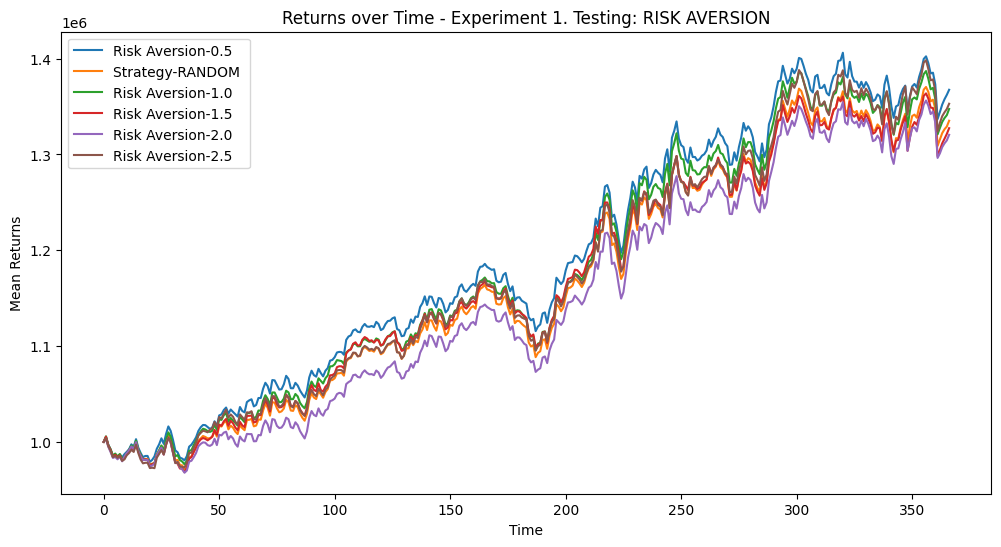

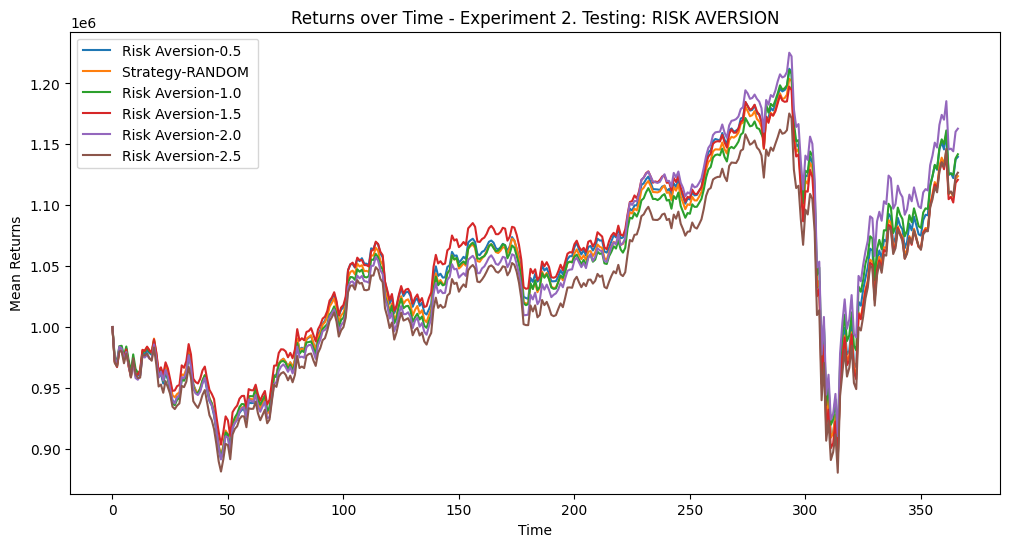

Experiment: RISK AVERSION. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
36.75,41.632,37.6175,0,0.10651,1101,0.451851


Experiment: RISK AVERSION. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.976,21.776,47.7296,0,0.02723,1101,1.14011


Experiment: RISK AVERSION. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.5182,38.1608,39.0303,0,0.098636,1101,0.108492


Experiment: RISK AVERSION. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.3916,20.5408,48.3562,0,0.026032,1101,0.0993764


Experiment: RISK AVERSION. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.748,40.104,37.6068,0,0.10059,1101,0.351043


Experiment: RISK AVERSION. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
14.186,21.17,47.5874,0,0.02968,1101,0.513671


Experiment: RISK AVERSION. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.739,37.512,39.9981,0,0.09606,1101,0.46136


Experiment: RISK AVERSION. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.087,20.174,49.2343,0,0.02481,1101,0.574286


Experiment: RISK AVERSION. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.051,37.133,39.44,0,0.09666,1101,0.290541


Experiment: RISK AVERSION. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.289,22.908,46.5941,0,0.03333,1101,0.404535


Experiment: RISK AVERSION. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.289,40.549,39.7851,0,0.09647,1101,1.12922


Experiment: RISK AVERSION. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.671,18.485,48.924,0,0.02621,1101,0.78412


TESTING LSTM OUTPUT SIZE


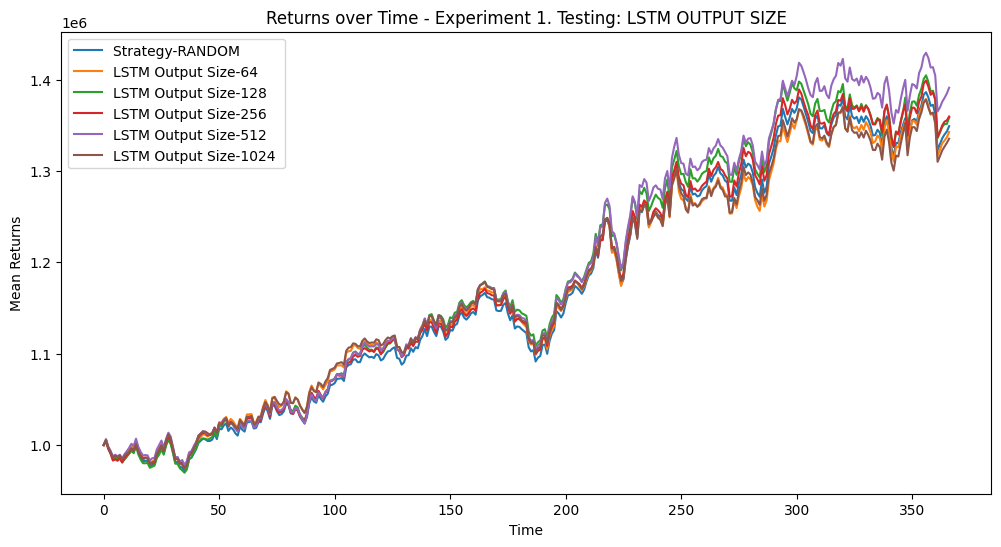

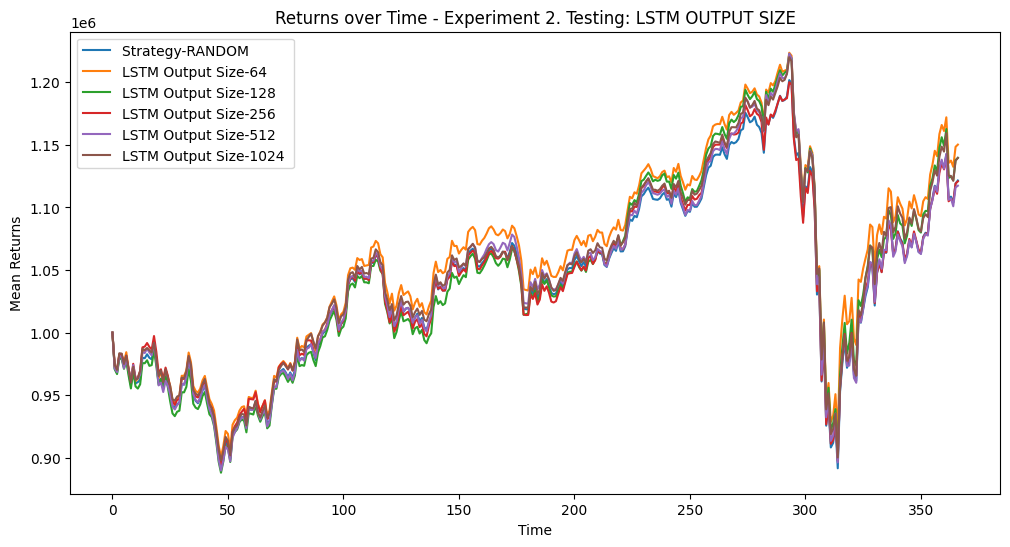

Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
36.75,41.632,37.6175,0,0.10651,1101,0.451851


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.976,21.776,47.7296,0,0.02723,1101,1.14011


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.9064,39.6118,38.8065,0,0.10182,1101,0.056642


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.151,20.3376,48.6969,0,0.025637,1101,0.0482706


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.748,40.104,37.6068,0,0.10059,1101,0.351043


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
14.186,21.17,47.5874,0,0.02968,1101,0.513671


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.739,37.512,39.9981,0,0.09606,1101,0.46136


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.087,20.174,49.2343,0,0.02481,1101,0.574286


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.051,37.133,39.44,0,0.09666,1101,0.290541


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.289,22.908,46.5941,0,0.03333,1101,0.404535


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.289,40.549,39.7851,0,0.09647,1101,1.12922


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.671,18.485,48.924,0,0.02621,1101,0.78412


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.259,38.693,37.9255,0,0.09896,1101,0.534357


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.018,22.446,46.5825,0,0.03114,1101,0.511754


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.829,41.513,38.6053,0,0.09988,1101,0.922594


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.957,22.465,47.3399,0,0.02831,1101,0.66479


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.958,40.867,40.964,0,0.10462,1101,0.465305


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.079,20.719,48.8245,0,0.02469,1101,0.7422


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
39.108,44.068,39.1568,0,0.1067,1101,0.731372


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.735,22.283,47.6139,0,0.02384,1101,0.610043


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.527,38.536,35.0515,0,0.09345,1101,0.79038


Experiment: LSTM OUTPUT SIZE. MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.956,22.993,46.9784,0,0.02758,1101,1.1788


TESTING REWARD FUNCTION


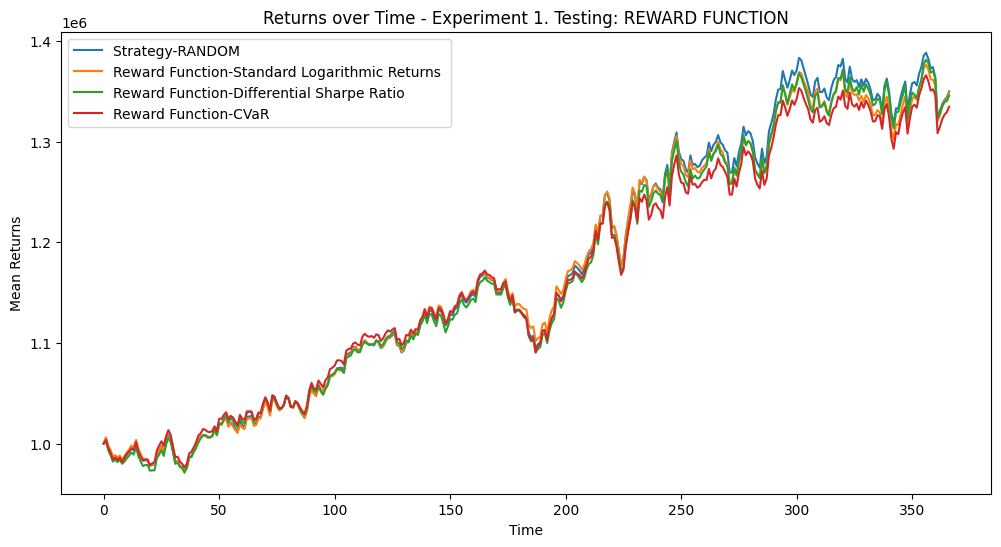

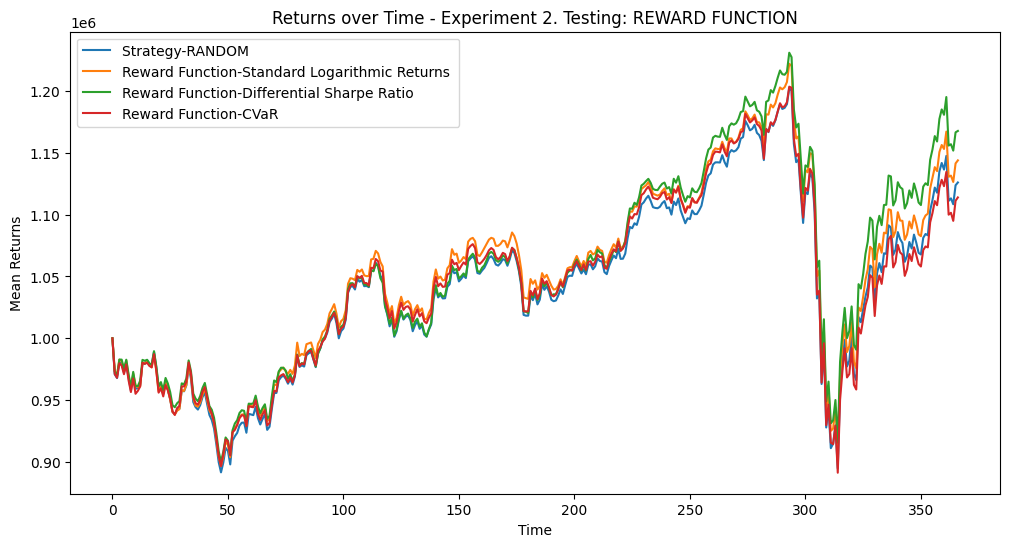

Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
36.75,41.632,37.6175,0,0.10651,1101,0.451851


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.976,21.776,47.7296,0,0.02723,1101,1.14011


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.0005,39.83,38.7274,0,0.101828,1101,0.0440449


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.5958,20.3841,48.7531,0,0.0265754,1101,0.0369604


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.748,40.104,37.6068,0,0.10059,1101,0.351043


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
14.186,21.17,47.5874,0,0.02968,1101,0.513671


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.739,37.512,39.9981,0,0.09606,1101,0.46136


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.087,20.174,49.2343,0,0.02481,1101,0.574286


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.051,37.133,39.44,0,0.09666,1101,0.290541


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.289,22.908,46.5941,0,0.03333,1101,0.404535


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.289,40.549,39.7851,0,0.09647,1101,1.12922


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.671,18.485,48.924,0,0.02621,1101,0.78412


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.259,38.693,37.9255,0,0.09896,1101,0.534357


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.018,22.446,46.5825,0,0.03114,1101,0.511754


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.829,41.513,38.6053,0,0.09988,1101,0.922594


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.957,22.465,47.3399,0,0.02831,1101,0.66479


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.958,40.867,40.964,0,0.10462,1101,0.465305


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.079,20.719,48.8245,0,0.02469,1101,0.7422


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
39.108,44.068,39.1568,0,0.1067,1101,0.731372


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.735,22.283,47.6139,0,0.02384,1101,0.610043


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.527,38.536,35.0515,0,0.09345,1101,0.79038


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.956,22.993,46.9784,0,0.02758,1101,1.1788


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.881,38.507,36.591,0,0.10217,1101,0.696302


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
14.382,22.954,47.6975,0,0.0295,1101,0.813798


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.582,39.116,38.3185,0,0.09833,1101,0.389157


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.762,23.376,48.5206,0,0.03416,1101,0.716254


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.481,37.422,38.4742,0,0.1009,1101,0.655038


Experiment: REWARD FUNCTION. MEAN RESULTS FOR: Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.386,20.6,49.3364,0,0.02394,1101,0.596128


TESTING LEARNING FREQUENCY


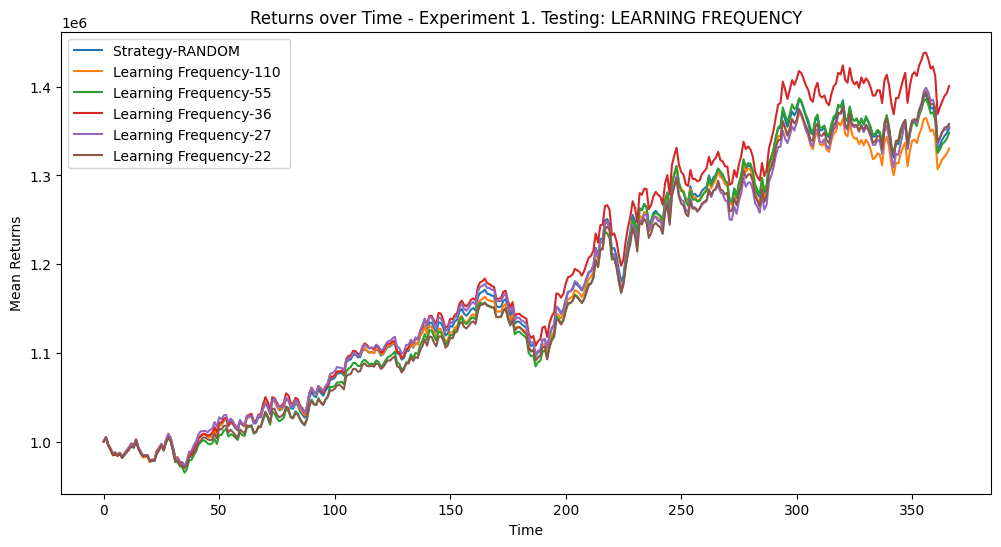

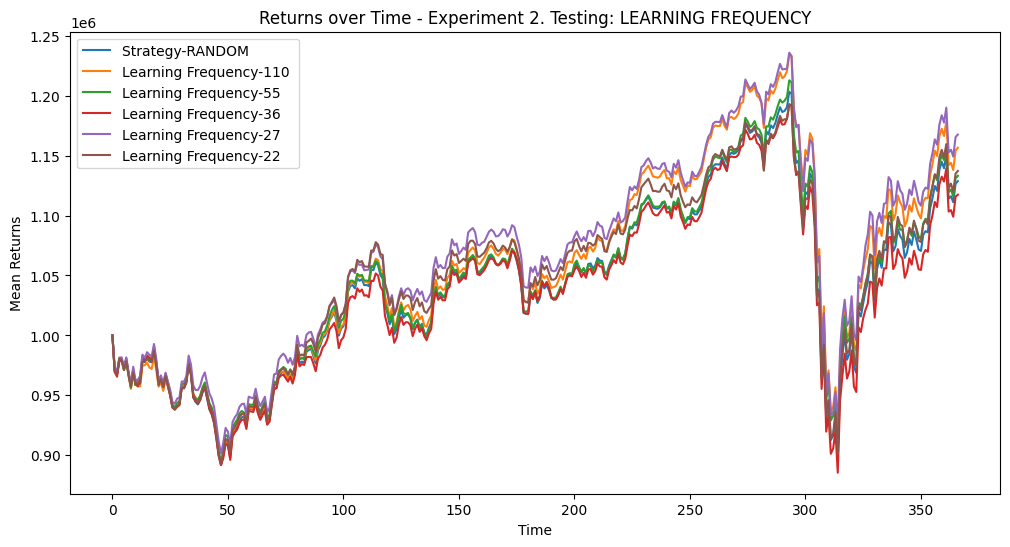

Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
36.75,41.632,37.6175,0,0.10651,1101,0.451851


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.976,21.776,47.7296,0,0.02723,1101,1.14011


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.3419,40.0303,38.7879,0,0.102711,1101,0.030474


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.8757,20.5066,48.7865,0,0.0270828,1101,0.0287519


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.748,40.104,37.6068,0,0.10059,1101,0.351043


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
14.186,21.17,47.5874,0,0.02968,1101,0.513671


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.739,37.512,39.9981,0,0.09606,1101,0.46136


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.087,20.174,49.2343,0,0.02481,1101,0.574286


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.051,37.133,39.44,0,0.09666,1101,0.290541


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.289,22.908,46.5941,0,0.03333,1101,0.404535


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.289,40.549,39.7851,0,0.09647,1101,1.12922


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.671,18.485,48.924,0,0.02621,1101,0.78412


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.259,38.693,37.9255,0,0.09896,1101,0.534357


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.018,22.446,46.5825,0,0.03114,1101,0.511754


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.829,41.513,38.6053,0,0.09988,1101,0.922594


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.957,22.465,47.3399,0,0.02831,1101,0.66479


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.958,40.867,40.964,0,0.10462,1101,0.465305


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.079,20.719,48.8245,0,0.02469,1101,0.7422


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
39.108,44.068,39.1568,0,0.1067,1101,0.731372


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.735,22.283,47.6139,0,0.02384,1101,0.610043


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.527,38.536,35.0515,0,0.09345,1101,0.79038


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.956,22.993,46.9784,0,0.02758,1101,1.1788


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.881,38.507,36.591,0,0.10217,1101,0.696302


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
14.382,22.954,47.6975,0,0.0295,1101,0.813798


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.582,39.116,38.3185,0,0.09833,1101,0.389157


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.762,23.376,48.5206,0,0.03416,1101,0.716254


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.481,37.422,38.4742,0,0.1009,1101,0.655038


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.386,20.6,49.3364,0,0.02394,1101,0.596128


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Learning Frequency-110 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.032,37.979,38.9301,0,0.09739,1101,0.426302


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Learning Frequency-110 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.659,23.493,47.9004,0,0.03204,1101,0.607761


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Learning Frequency-55 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.837,40.229,37.1229,0,0.10115,1101,0.821062


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Learning Frequency-55 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.32,21.378,46.6173,0,0.02763,1101,0.801366


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Learning Frequency-36 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
40.088,44.469,39.3416,0,0.11042,1101,0.73985


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Learning Frequency-36 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.743,19.646,50.163,0,0.02432,1101,0.728028


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Learning Frequency-27 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.558,40.779,38.6307,0,0.09976,1101,0.689169


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Learning Frequency-27 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.757,24.408,47.1337,0,0.0332,1101,0.920367


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Learning Frequency-22 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.809,40.343,39.3589,0,0.10056,1101,1.10502


Experiment: LEARNING FREQUENCY. MEAN RESULTS FOR: Learning Frequency-22 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.722,19.95,48.9183,0,0.02834,1101,0.770317


TESTING PARALLEL ENVIRONMENTS


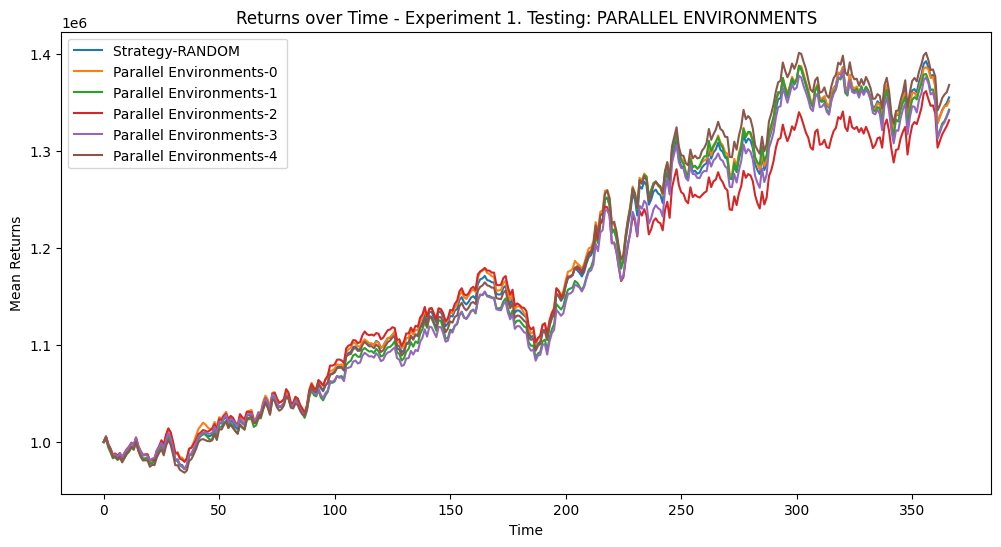

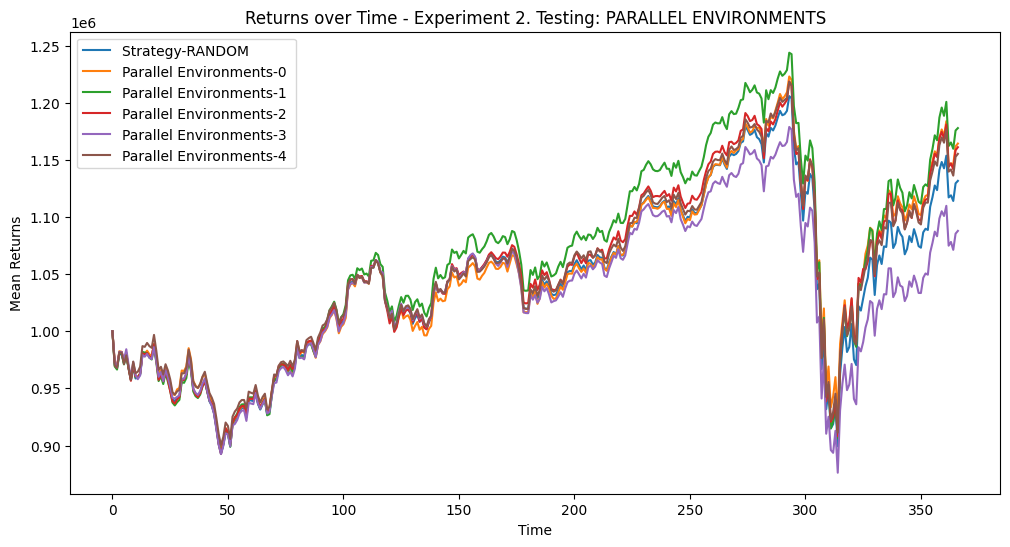

Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
36.75,41.632,37.6175,0,0.10651,1101,0.451851


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.976,21.776,47.7296,0,0.02723,1101,1.14011


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.5007,40.1543,38.8935,0,0.103155,1101,0.0243046


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.157,20.775,48.745,0,0.0275796,1101,0.0236896


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.748,40.104,37.6068,0,0.10059,1101,0.351043


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
14.186,21.17,47.5874,0,0.02968,1101,0.513671


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.739,37.512,39.9981,0,0.09606,1101,0.46136


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.087,20.174,49.2343,0,0.02481,1101,0.574286


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.051,37.133,39.44,0,0.09666,1101,0.290541


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.289,22.908,46.5941,0,0.03333,1101,0.404535


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.289,40.549,39.7851,0,0.09647,1101,1.12922


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.671,18.485,48.924,0,0.02621,1101,0.78412


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.259,38.693,37.9255,0,0.09896,1101,0.534357


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.018,22.446,46.5825,0,0.03114,1101,0.511754


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.829,41.513,38.6053,0,0.09988,1101,0.922594


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.957,22.465,47.3399,0,0.02831,1101,0.66479


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.958,40.867,40.964,0,0.10462,1101,0.465305


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.079,20.719,48.8245,0,0.02469,1101,0.7422


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
39.108,44.068,39.1568,0,0.1067,1101,0.731372


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.735,22.283,47.6139,0,0.02384,1101,0.610043


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.527,38.536,35.0515,0,0.09345,1101,0.79038


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.956,22.993,46.9784,0,0.02758,1101,1.1788


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.881,38.507,36.591,0,0.10217,1101,0.696302


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
14.382,22.954,47.6975,0,0.0295,1101,0.813798


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.582,39.116,38.3185,0,0.09833,1101,0.389157


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.762,23.376,48.5206,0,0.03416,1101,0.716254


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.481,37.422,38.4742,0,0.1009,1101,0.655038


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.386,20.6,49.3364,0,0.02394,1101,0.596128


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Learning Frequency-110 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.032,37.979,38.9301,0,0.09739,1101,0.426302


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Learning Frequency-110 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.659,23.493,47.9004,0,0.03204,1101,0.607761


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Learning Frequency-55 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.837,40.229,37.1229,0,0.10115,1101,0.821062


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Learning Frequency-55 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.32,21.378,46.6173,0,0.02763,1101,0.801366


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Learning Frequency-36 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
40.088,44.469,39.3416,0,0.11042,1101,0.73985


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Learning Frequency-36 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.743,19.646,50.163,0,0.02432,1101,0.728028


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Learning Frequency-27 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.558,40.779,38.6307,0,0.09976,1101,0.689169


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Learning Frequency-27 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.757,24.408,47.1337,0,0.0332,1101,0.920367


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Learning Frequency-22 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.809,40.343,39.3589,0,0.10056,1101,1.10502


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Learning Frequency-22 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.722,19.95,48.9183,0,0.02834,1101,0.770317


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Parallel Environments-0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.118,40.411,36.8299,0,0.10036,1101,0.762687


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Parallel Environments-0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.422,22.527,48.9659,0,0.03348,1101,0.848538


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Parallel Environments-1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.245,39.714,39.899,0,0.09668,1101,0.698679


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Parallel Environments-1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
17.775,25.504,49.2148,0,0.03384,1101,1.13488


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Parallel Environments-2 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.146,36.495,39.2705,0,0.09826,1101,0.901531


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Parallel Environments-2 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.104,22.502,48.304,0,0.0328,1101,0.578597


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Parallel Environments-3 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.106,39.264,37.3973,0,0.0986,1101,0.466249


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Parallel Environments-3 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
8.781,18.009,48.8807,0,0.01886,1101,0.486976


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Parallel Environments-4 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
36.786,41.392,39.5897,0,0.10605,1101,0.723967


Experiment: PARALLEL ENVIRONMENTS. MEAN RESULTS FOR: Parallel Environments-4 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.52,22.338,47.744,0,0.03205,1101,0.610829


TESTING LEARNING RATE


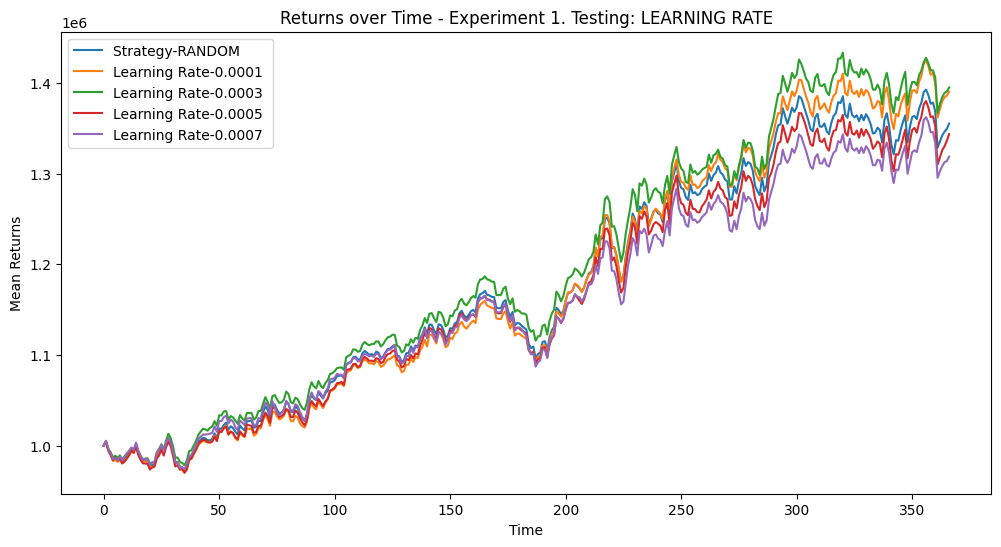

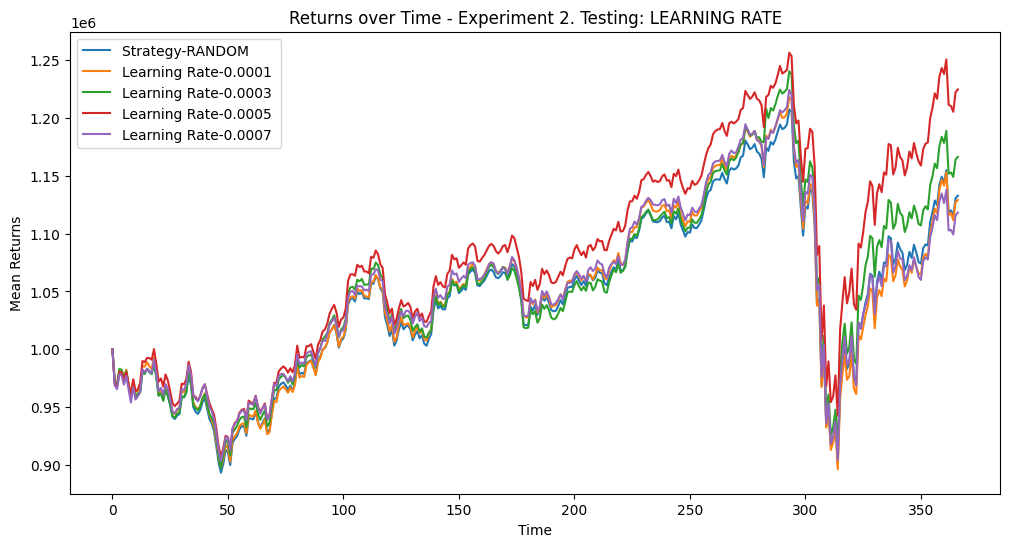

Experiment: LEARNING RATE. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
36.75,41.632,37.6175,0,0.10651,1101,0.451851


Experiment: LEARNING RATE. MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.976,21.776,47.7296,0,0.02723,1101,1.14011


Experiment: LEARNING RATE. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.5282,40.1549,38.6925,0,0.10318,1101,0.0206504


Experiment: LEARNING RATE. MEAN RESULTS FOR: Strategy-RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.2798,20.9209,48.7163,0,0.0278067,1101,0.0198185


Experiment: LEARNING RATE. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.748,40.104,37.6068,0,0.10059,1101,0.351043


Experiment: LEARNING RATE. MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
14.186,21.17,47.5874,0,0.02968,1101,0.513671


Experiment: LEARNING RATE. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.739,37.512,39.9981,0,0.09606,1101,0.46136


Experiment: LEARNING RATE. MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.087,20.174,49.2343,0,0.02481,1101,0.574286


Experiment: LEARNING RATE. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
32.051,37.133,39.44,0,0.09666,1101,0.290541


Experiment: LEARNING RATE. MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.289,22.908,46.5941,0,0.03333,1101,0.404535


Experiment: LEARNING RATE. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.289,40.549,39.7851,0,0.09647,1101,1.12922


Experiment: LEARNING RATE. MEAN RESULTS FOR: Risk Aversion-2.5 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.671,18.485,48.924,0,0.02621,1101,0.78412


Experiment: LEARNING RATE. MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.259,38.693,37.9255,0,0.09896,1101,0.534357


Experiment: LEARNING RATE. MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.018,22.446,46.5825,0,0.03114,1101,0.511754


Experiment: LEARNING RATE. MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.829,41.513,38.6053,0,0.09988,1101,0.922594


Experiment: LEARNING RATE. MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.957,22.465,47.3399,0,0.02831,1101,0.66479


Experiment: LEARNING RATE. MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.958,40.867,40.964,0,0.10462,1101,0.465305


Experiment: LEARNING RATE. MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.079,20.719,48.8245,0,0.02469,1101,0.7422


Experiment: LEARNING RATE. MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
39.108,44.068,39.1568,0,0.1067,1101,0.731372


Experiment: LEARNING RATE. MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.735,22.283,47.6139,0,0.02384,1101,0.610043


Experiment: LEARNING RATE. MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.527,38.536,35.0515,0,0.09345,1101,0.79038


Experiment: LEARNING RATE. MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.956,22.993,46.9784,0,0.02758,1101,1.1788


Experiment: LEARNING RATE. MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.881,38.507,36.591,0,0.10217,1101,0.696302


Experiment: LEARNING RATE. MEAN RESULTS FOR: Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
14.382,22.954,47.6975,0,0.0295,1101,0.813798


Experiment: LEARNING RATE. MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.582,39.116,38.3185,0,0.09833,1101,0.389157


Experiment: LEARNING RATE. MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.762,23.376,48.5206,0,0.03416,1101,0.716254


Experiment: LEARNING RATE. MEAN RESULTS FOR: Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.481,37.422,38.4742,0,0.1009,1101,0.655038


Experiment: LEARNING RATE. MEAN RESULTS FOR: Reward Function-CVaR | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.386,20.6,49.3364,0,0.02394,1101,0.596128


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Frequency-110 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.032,37.979,38.9301,0,0.09739,1101,0.426302


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Frequency-110 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.659,23.493,47.9004,0,0.03204,1101,0.607761


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Frequency-55 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.837,40.229,37.1229,0,0.10115,1101,0.821062


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Frequency-55 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.32,21.378,46.6173,0,0.02763,1101,0.801366


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Frequency-36 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
40.088,44.469,39.3416,0,0.11042,1101,0.73985


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Frequency-36 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.743,19.646,50.163,0,0.02432,1101,0.728028


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Frequency-27 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.558,40.779,38.6307,0,0.09976,1101,0.689169


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Frequency-27 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.757,24.408,47.1337,0,0.0332,1101,0.920367


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Frequency-22 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.809,40.343,39.3589,0,0.10056,1101,1.10502


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Frequency-22 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
13.722,19.95,48.9183,0,0.02834,1101,0.770317


Experiment: LEARNING RATE. MEAN RESULTS FOR: Parallel Environments-0 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
35.118,40.411,36.8299,0,0.10036,1101,0.762687


Experiment: LEARNING RATE. MEAN RESULTS FOR: Parallel Environments-0 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.422,22.527,48.9659,0,0.03348,1101,0.848538


Experiment: LEARNING RATE. MEAN RESULTS FOR: Parallel Environments-1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.245,39.714,39.899,0,0.09668,1101,0.698679


Experiment: LEARNING RATE. MEAN RESULTS FOR: Parallel Environments-1 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
17.775,25.504,49.2148,0,0.03384,1101,1.13488


Experiment: LEARNING RATE. MEAN RESULTS FOR: Parallel Environments-2 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
33.146,36.495,39.2705,0,0.09826,1101,0.901531


Experiment: LEARNING RATE. MEAN RESULTS FOR: Parallel Environments-2 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.104,22.502,48.304,0,0.0328,1101,0.578597


Experiment: LEARNING RATE. MEAN RESULTS FOR: Parallel Environments-3 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.106,39.264,37.3973,0,0.0986,1101,0.466249


Experiment: LEARNING RATE. MEAN RESULTS FOR: Parallel Environments-3 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
8.781,18.009,48.8807,0,0.01886,1101,0.486976


Experiment: LEARNING RATE. MEAN RESULTS FOR: Parallel Environments-4 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
36.786,41.392,39.5897,0,0.10605,1101,0.723967


Experiment: LEARNING RATE. MEAN RESULTS FOR: Parallel Environments-4 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.52,22.338,47.744,0,0.03205,1101,0.610829


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Rate-0.0001 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
39.044,42.933,38.9171,0,0.11245,1101,0.812702


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Rate-0.0001 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
12.909,21.838,48.0315,0,0.02694,1101,0.344419


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Rate-0.0003 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
39.518,44.599,38.0762,0,0.10965,1101,0.564837


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Rate-0.0003 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.638,24.269,47.7756,0,0.03311,1101,1.02995


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Rate-0.0005 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.37,38.643,39.0789,0,0.09344,1101,0.571307


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Rate-0.0005 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
22.474,28.062,47.3276,0,0.0416,1101,1.3353


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Rate-0.0007 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
31.883,36.934,40.979,0,0.09162,1101,0.731772


Experiment: LEARNING RATE. MEAN RESULTS FOR: Learning Rate-0.0007 | Strategy-PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.821,22.478,47.0396,0,0.02312,1101,0.923561


In [16]:
def test():
    for testType, active in TESTING.items():
        if active:
            print(f"TESTING {testType.replace('_', ' ').upper()}")
            testLoops = {
                "RISK AVERSION": lambda: [
                    trainingLoop(riskAversion=risk) for risk in AGENT_RISK_AVERSIONS
                ],
                "LSTM OUTPUT SIZE": lambda: [
                    trainingLoop(lstmOutputSize=size) for size in LSTMOUTPUTSIZES
                ],
                "REWARD FUNCTION": lambda: [
                    trainingLoop(
                        riskAversion=(1.5 if r == "CVaR" else 0), rewardFunction=r
                    )
                    for r in REWARD_FUNCTIONS
                ],
                "LEARNING FREQUENCY": lambda: [
                    trainingLoop(freq=fr) for fr in LEARNING_FREQUENCIES
                ],
                "PARALLEL ENVIRONMENTS": lambda: [
                    trainingLoop(parr=par) for par in NUMBER_OF_PARALLEL_ENVIRONMENTS
                ],
                "LEARNING RATE": lambda: [
                    trainingLoop(lr=learn) for learn in LEARNING_RATES
                ],
            }
            
            testLoops[testType]()
            break 


def run_tests():
    for key in TESTING.keys():
        print("=" * 50)
        TESTING[key] = True
        allResults = defaultdict(list) 
        test()
        plotPerformance(key)
        tabulateResults(key)
        TESTING[key] = False
        print("=" * 50)


# Run the tests
run_tests()

### Best Models (if any) Evaluated 

In [17]:
# REMEMBER TO VARY BUT REPEAT SEEDS